# Applying YOLOv5s for Traffic Sign Recognition - Data Preprocessor

This is the code used for basic data preprocessing: resolving the class imbalance issue and saving everything in the format supported by YOLO

## 0. Preparation

In [1]:
import os
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import RandomOverSampler

In [2]:
dataset_path = "data"

# open the CSVs with annotations
df = pd.read_csv(os.path.join(dataset_path, "Train.csv"))
test_df = pd.read_csv(os.path.join(dataset_path, "Test.csv"))
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [3]:
# split train data into train and validation (80/20), preserve the ratio of classes
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["ClassId"], random_state=42)

## 1. Addressing class imbalance

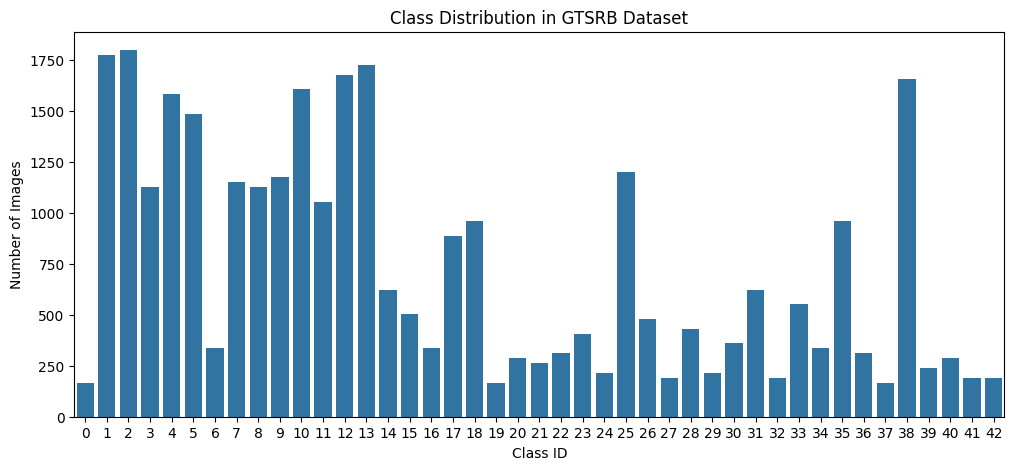

In [4]:
class_counts = train_df["ClassId"].value_counts().sort_index()

# plot class distribution
plt.figure(figsize=(12,5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.title("Class Distribution in GTSRB Dataset")
plt.show()

In [5]:
# find quantiles
Q1, Q2, Q3 = np.quantile(class_counts.values, [0.25, 0.5, 0.75])
Q1, Q2, Q3

(np.float64(276.0), np.float64(480.0), np.float64(1140.0))

This is a complicated case of class imbalance. I decided to divide classes into quantiles, not to upsample classes over Q2, upsample classes between Q1 and Q2 to (Q2 + Q3) / 2, and upsample classes under Q1 to Q2. This should provide some balance between classes while avoiding overfitting on rare cases

In [6]:
# create a dictionary for the oversampler
resample_dict = {}

for label, count in zip(class_counts.index, class_counts.values):
    if count >= Q2:
        resample_dict[label] = 0
    if count < Q2 and count >= Q1:
        resample_dict[label] = (Q2 + Q3) // 2 - count
    else:
        resample_dict[label] = Q2 - count

In [7]:
# oversample the training set
ros = RandomOverSampler(random_state=42)
train_df_resampled, _ = ros.fit_resample(train_df, train_df["ClassId"])

## 2. Converting to the format required by YOLO

In [8]:
output_path = "data-yolo"

# output folders in format required by YOLO
os.makedirs(f"{output_path}/images/train", exist_ok=True)
os.makedirs(f"{output_path}/images/val", exist_ok=True)
os.makedirs(f"{output_path}/images/test", exist_ok=True)
os.makedirs(f"{output_path}/labels/train", exist_ok=True)
os.makedirs(f"{output_path}/labels/val", exist_ok=True)
os.makedirs(f"{output_path}/labels/test", exist_ok=True)

In [9]:
# to save oversampled images correctly, duplicate files need to be named differently
duplicate_counts = {}

In [10]:
# function for converting a dataset to YOLO format
def convert_to_yolo(df, split):
    # iterate through the rows of the dataset
    for _, row in df.iterrows():
        # read the image from the path
        img_path = os.path.join(dataset_path, row["Path"])
        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        # normalize bounding box (required by YOLO)
        x_center = (row["Roi.X1"] + row["Roi.X2"]) / (2 * w)
        y_center = (row["Roi.Y1"] + row["Roi.Y2"]) / (2 * h)
        bbox_width = (row["Roi.X2"] - row["Roi.X1"]) / w
        bbox_height = (row["Roi.Y2"] - row["Roi.Y1"]) / h

        # get the original file name from path
        if split == "train" or split == "val":
            img_file_name = row["Path"].replace("Train/", "")
            img_file_name = img_file_name[img_file_name.find("/") + 1:]
        else:
            img_file_name = row["Path"].replace("Test/", "")

        # handle duplicates - modify the name if necessary
        if img_file_name in duplicate_counts:
            duplicate_counts[img_file_name] += 1
            img_file_name = f"{img_file_name.replace('.png', '')}_copy{duplicate_counts[img_file_name]}.png"
        else:
            duplicate_counts[img_file_name] = 0
        
        # save the image
        dest_img_path = f"{output_path}/images/{split}/{img_file_name}"
        cv2.imwrite(dest_img_path, img)

        # get the label file name and save the file
        label_file_name = img_file_name.replace('.png', '.txt')
        label_path = f"{output_path}/labels/{split}/{label_file_name}"
        with open(label_path, "w") as f:
            f.write(f"{row['ClassId']} {x_center} {y_center} {bbox_width} {bbox_height}\n")

In [11]:
# convert train and validation sets
convert_to_yolo(train_df_resampled, "train")
convert_to_yolo(val_df, "val")
convert_to_yolo(test_df, "test")